In [1]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings("ignore")

sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

symbols_list = sp500['Symbol'].unique().tolist()

end_date = '2023-09-27'

start_date = pd.to_datetime(end_date) - pd.DateOffset(years=8)

df = yf.download(symbols_list, start=start_date, end=end_date).stack()

df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

df

[*********************100%%**********************]  503 of 503 completed


1 Failed download:
['VLTO']: Exception("%ticker%: Data doesn't exist for startDate = 1443326400, endDate = 1695787200")


adj close       close        high         low        open  \
date       ticker                                                               
2015-09-28 A        31.241646   33.369999   34.270000   33.320000   34.130001   
           AAL      37.266262   39.080002   40.180000   38.639999   39.869999   
           AAPL     25.482073   28.110001   28.642500   28.110001   28.462500   
           ABBV     36.821239   52.500000   55.430000   52.340000   55.389999   
           ABT      33.430687   39.060001   40.740002   39.000000   40.740002   
...                       ...         ...         ...         ...         ...   
2023-09-26 YUM     123.426186  124.010002  124.739998  123.449997  124.239998   
           ZBH     112.216316  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZION     33.581326   33.990002   34.700001   33.840000   33.840000   
           ZTS     176.447540  176.869995  178.449997  176.270004  176.580002   

                        volume  
date       ticker               
2015-09-28 A         2615400.0  
           AAL       9635900.0  
           AAPL    208436000.0  
           ABBV     15123000.0  
           ABT      17219300.0  
...                        ...  
2023-09-26 YUM       1500600.0  
           ZBH       3610500.0  
           ZBRA       355400.0  
           ZION      1586100.0  
           ZTS       1463200.0  

[994571 rows x 6 columns]

## **2. Calculate features and technical indicators for each stock.**
* Garman-Klass Volatility
* RSI
* Bollinger Bands
* ATR
* MACD
* Dollar Volume

In [2]:
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2 - (2*np.log(2)-1)*(np.log(df['close'])-np.log(df['open']))**2

df['rsi'] = df.groupby(level='ticker')['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

df['bb_low'] = df.groupby(level='ticker')['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:, 0])

df['bb_mid'] = df.groupby(level='ticker')['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:, 1])

df['bb_high'] = df.groupby(level='ticker')['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:, 2])

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'], low=stock_data['low'], close=stock_data['adj close'], length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level='ticker', group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:, 0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level='ticker')['adj close'].transform(compute_macd)

df['dollar_volume'] = (df['adj close']*df['volume'])/1e6

df

adj close       close        high         low        open  \
date       ticker                                                               
2015-09-28 A        31.241646   33.369999   34.270000   33.320000   34.130001   
           AAL      37.266262   39.080002   40.180000   38.639999   39.869999   
           AAPL     25.482073   28.110001   28.642500   28.110001   28.462500   
           ABBV     36.821239   52.500000   55.430000   52.340000   55.389999   
           ABT      33.430687   39.060001   40.740002   39.000000   40.740002   
...                       ...         ...         ...         ...         ...   
2023-09-26 YUM     123.426186  124.010002  124.739998  123.449997  124.239998   
           ZBH     112.216316  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZION     33.581326   33.990002   34.700001   33.840000   33.840000   
           ZTS     176.447540  176.869995  178.449997  176.270004  176.580002   

                        volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2015-09-28 A         2615400.0          0.000199        NaN       NaN   
           AAL       9635900.0          0.000609        NaN       NaN   
           AAPL    208436000.0          0.000116        NaN       NaN   
           ABBV     15123000.0          0.000536        NaN       NaN   
           ABT      17219300.0          0.000268        NaN       NaN   
...                        ...               ...        ...       ...   
2023-09-26 YUM       1500600.0          0.000053  36.057200  4.821521   
           ZBH       3610500.0          0.000289  31.893246  4.751923   
           ZBRA       355400.0          0.000133  29.494977  5.400991   
           ZION      1586100.0          0.000307  46.707775  3.527329   
           ZTS       1463200.0          0.000075  42.623483  5.161192   

                     bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2015-09-28 A            NaN       NaN       NaN       NaN      81.709400  
           AAL          NaN       NaN       NaN       NaN     359.093975  
           AAPL         NaN       NaN       NaN       NaN    5311.381332  
           ABBV         NaN       NaN       NaN       NaN     556.847605  
           ABT          NaN       NaN       NaN       NaN     575.653028  
...                     ...       ...       ...       ...            ...  
2023-09-26 YUM     4.851489  4.881456 -2.623489 -1.363306     185.213334  
           ZBH     4.791592  4.831260 -1.977381 -0.881471     405.157010  
           ZBRA    5.539167  5.677342 -0.056874 -1.601131      79.595386  
           ZION    3.582765  3.638202 -2.304808 -0.164823      53.263340  
           ZTS     5.220007  5.278822 -0.587309 -1.188421     258.178041  

[994571 rows x 14 columns]

## **3. Aggregate to monthly level and filter top 150 most liquid stocks for each month.**

* To reduce training time and experiment with features and strategies, we convert the business-daily data to month-end frequency.

In [3]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'open', 'high', 'low', 'close', 'volume']]

data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
           df.unstack()[last_cols].resample('M').last().stack('ticker')], axis=1)).dropna()

data



dollar_volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2015-11-30 A          136.444133   39.152695          0.000050  73.544039   
           AAL        287.915802   39.429935          0.000243  40.794304   
           AAPL      4034.583801   26.924879          0.000095  54.676809   
           ABBV       343.971747   41.160294          0.000362  49.466775   
           ABT        213.736357   38.669403          0.000043  57.238902   
...                          ...         ...               ...        ...   
2023-09-30 OTIS       155.565476   78.967529          0.000093  33.116240   
           ABNB      1633.500725  132.279999          0.000213  44.494127   
           CEG        197.358104  108.239204          0.000274  55.245464   
           GEHC       212.434213   66.179550          0.000185  40.922330   
           KVUE       684.902631   20.426666          0.000158  35.706317   

                     bb_low    bb_mid   bb_high       atr      macd  
date       ticker                                                    
2015-11-30 A       3.549210  3.621664  3.694119 -0.793744  0.568319  
           AAL     3.672028  3.749832  3.827635  1.472727 -0.413408  
           AAPL    3.284211  3.327527  3.370842 -0.268280 -0.151141  
           ABBV    3.745051  3.793320  3.841588  0.671131  0.125472  
           ABT     3.665571  3.687430  3.709289  0.819534  0.333750  
...                     ...       ...       ...       ...       ...  
2023-09-30 OTIS    4.377807  4.423099  4.468390 -2.129325 -1.534536  
           ABNB    4.857047  4.940924  5.024801 -1.006939 -0.037854  
           CEG     4.655604  4.695779  4.735953 -0.665290  0.366876  
           GEHC    4.156170  4.213706  4.271243 -0.898879 -1.116463  
           KVUE    3.034066  3.109082  3.184098 -2.357939 -1.435621  

[46937 rows x 9 columns]

* Calculate 5-year rolling average of dollar volume for each stocks before filtering.

In [4]:
data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = data.groupby('date')['dollar_volume'].rank(ascending=False)

data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2016-10-31 AAL      39.134331          0.000143  62.203529  3.604673   
           AAPL     26.281523          0.000041  49.891098  3.296770   
           ABBV     41.009071          0.000192  27.477844  3.771813   
           ABT      34.630032          0.000024  38.008842  3.564121   
           ACN     104.350319          0.000033  53.823688  4.644779   
...                       ...               ...        ...       ...   
2023-09-30 WFC      40.290813          0.000234  40.920287  3.709473   
           WMT     162.500000          0.000024  54.722508  5.081613   
           XOM     115.355156          0.000045  59.440186  4.704273   
           MRNA     98.120003          0.000146  38.747314  4.582514   
           ABNB    132.279999          0.000213  44.494127  4.857047   

                     bb_mid   bb_high       atr      macd  
date       ticker                                          
2016-10-31 AAL     3.655493  3.706314  1.159354  1.127774  
           AAPL    3.325653  3.354535 -0.927588 -0.195865  
           ABBV    3.826001  3.880188  0.371044 -0.760499  
           ABT     3.614608  3.665095 -0.212940 -0.651383  
           ACN     4.656418  4.668056  0.478809 -0.136004  
...                     ...       ...       ...       ...  
2023-09-30 WFC     3.749849  3.790225 -1.461782 -0.282936  
           WMT     5.099300  5.116986 -2.381473  0.400089  
           XOM     4.744375  4.784477 -1.416926  1.399850  
           MRNA    4.685332  4.788149 -0.529511 -0.376899  
           ABNB    4.940924  5.024801 -1.006939 -0.037854  

[12516 rows x 8 columns]

## **4. Calculate Monthly Returns for different time horizons as features.**

* To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method .pct_change(lag), that is, returns over various monthly periods as identified by lags.

In [5]:
def calculate_returns(df):
    outlier_cutoff = 0.005
    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:
        df[f'return_{lag}m'] = df['adj close'].pct_change(lag).pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff), upper=x.quantile(1-outlier_cutoff))).add(1).pow(1/lag).sub(1)

    return df

data = data.groupby(level='ticker', group_keys=False).apply(calculate_returns).dropna()

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2017-10-31 AAL      45.534168          0.000119  41.051787  3.849110   
           AAPL     39.818504          0.000112  69.196772  3.597289   
           ABBV     68.772308          0.000173  55.247853  4.215227   
           ABT      48.969303          0.000036  53.844882  3.902136   
           ACN     130.375092          0.000019  69.365199  4.810123   
...                       ...               ...        ...       ...   
2023-09-30 WFC      40.290813          0.000234  40.920287  3.709473   
           WMT     162.500000          0.000024  54.722508  5.081613   
           XOM     115.355156          0.000045  59.440186  4.704273   
           MRNA     98.120003          0.000146  38.747314  4.582514   
           ABNB    132.279999          0.000213  44.494127  4.857047   

                     bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                      
2017-10-31 AAL     3.921750  3.994389  1.123293 -0.020265  -0.014108   
           AAPL    3.644164  3.691040 -0.509960 -0.039126   0.096807   
           ABBV    4.261600  4.307973  1.506177  0.474520   0.022728   
           ABT     3.925710  3.949284  0.161453  0.275616   0.021276   
           ACN     4.849805  4.889486  0.428072  0.351863   0.064180   
...                     ...       ...       ...       ...        ...   
2023-09-30 WFC     3.749849  3.790225 -1.461782 -0.282936  -0.015500   
           WMT     5.099300  5.116986 -2.381473  0.400089  -0.000676   
           XOM     4.744375  4.784477 -1.416926  1.399850   0.046947   
           MRNA    4.685332  4.788149 -0.529511 -0.376899  -0.132219   
           ABNB    4.940924  5.024801 -1.006939 -0.037854   0.005549   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2017-10-31 AAL      0.022981  -0.023860   0.016495   0.007008    0.012702  
           AAPL     0.015249   0.044955   0.028875   0.038941    0.035228  
           ABBV     0.098590   0.091379   0.056495   0.047273    0.044026  
           ABT      0.034308   0.034801   0.038672   0.031320    0.029294  
           ACN      0.048454   0.037203   0.028692   0.027398    0.018728  
...                      ...        ...        ...        ...         ...  
2023-09-30 WFC     -0.057917  -0.013554   0.016712   0.000702    0.003255  
           WMT      0.010014   0.012354   0.017574   0.016553    0.020256  
           XOM      0.046139   0.030496   0.012838   0.008747    0.027037  
           MRNA    -0.086803  -0.068763  -0.071952  -0.064976   -0.015431  
           ABNB    -0.067704   0.010603   0.010289   0.049124    0.019401  

[10340 rows x 14 columns]

## **5. Download Fama-French Factors and Calculate Rolling Factor Betas.**

* We will introduce the Fama-French data to estimate the exposure of assets to common risk factors using linear regression.

* The five Fama-French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models.

* We can access the historical factor returns using the pandas-datareader and estimate historical exposures using the RollingOLS rolling linear regression.

In [6]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.names = ['date']

factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2017-10-31 AAL     0.0225 -0.0194  0.0020  0.0093 -0.0325  -0.014108
           AAPL    0.0225 -0.0194  0.0020  0.0093 -0.0325   0.096807
           ABBV    0.0225 -0.0194  0.0020  0.0093 -0.0325   0.022728
           ABT     0.0225 -0.0194  0.0020  0.0093 -0.0325   0.021276
           ACN     0.0225 -0.0194  0.0020  0.0093 -0.0325   0.064180
...                   ...     ...     ...     ...     ...        ...
2023-09-30 VRTX   -0.0524 -0.0180  0.0152  0.0186 -0.0083   0.009617
           VZ     -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.056890
           WFC    -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.015500
           WMT    -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.000676
           XOM    -0.0524 -0.0180  0.0152  0.0186 -0.0083   0.046947

[10340 rows x 6 columns]

In [7]:
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2017-10-31 AAL     0.0225 -0.0194  0.0020  0.0093 -0.0325  -0.014108
           AAPL    0.0225 -0.0194  0.0020  0.0093 -0.0325   0.096807
           ABBV    0.0225 -0.0194  0.0020  0.0093 -0.0325   0.022728
           ABT     0.0225 -0.0194  0.0020  0.0093 -0.0325   0.021276
           ACN     0.0225 -0.0194  0.0020  0.0093 -0.0325   0.064180
...                   ...     ...     ...     ...     ...        ...
2023-09-30 VRTX   -0.0524 -0.0180  0.0152  0.0186 -0.0083   0.009617
           VZ     -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.056890
           WFC    -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.015500
           WMT    -0.0524 -0.0180  0.0152  0.0186 -0.0083  -0.000676
           XOM    -0.0524 -0.0180  0.0152  0.0186 -0.0083   0.046947

[10304 rows x 6 columns]

In [8]:
betas = (factor_data.groupby(level=1,group_keys=False).apply(lambda x: RollingOLS(endog=x['return_1m'], exog=sm.add_constant(x.drop('return_1m', axis=1)), window=min(24, x.shape[0]), min_nobs=len(x.columns)+1).fit(params_only=True).params.drop('const', axis=1)))

data = data.join(betas.groupby('ticker').shift())

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2017-10-31 AAL      45.534168          0.000119  41.051787  3.849110   
           AAPL     39.818504          0.000112  69.196772  3.597289   
           ABBV     68.772308          0.000173  55.247853  4.215227   
           ABT      48.969303          0.000036  53.844882  3.902136   
           ACN     130.375092          0.000019  69.365199  4.810123   
...                       ...               ...        ...       ...   
2023-09-30 WFC      40.290813          0.000234  40.920287  3.709473   
           WMT     162.500000          0.000024  54.722508  5.081613   
           XOM     115.355156          0.000045  59.440186  4.704273   
           MRNA     98.120003          0.000146  38.747314  4.582514   
           ABNB    132.279999          0.000213  44.494127  4.857047   

                     bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                      
2017-10-31 AAL     3.921750  3.994389  1.123293 -0.020265  -0.014108   
           AAPL    3.644164  3.691040 -0.509960 -0.039126   0.096807   
           ABBV    4.261600  4.307973  1.506177  0.474520   0.022728   
           ABT     3.925710  3.949284  0.161453  0.275616   0.021276   
           ACN     4.849805  4.889486  0.428072  0.351863   0.064180   
...                     ...       ...       ...       ...        ...   
2023-09-30 WFC     3.749849  3.790225 -1.461782 -0.282936  -0.015500   
           WMT     5.099300  5.116986 -2.381473  0.400089  -0.000676   
           XOM     4.744375  4.784477 -1.416926  1.399850   0.046947   
           MRNA    4.685332  4.788149 -0.529511 -0.376899  -0.132219   
           ABNB    4.940924  5.024801 -1.006939 -0.037854   0.005549   

                   return_2m  return_3m  return_6m  return_9m  return_12m  \
date       ticker                                                           
2017-10-31 AAL      0.022981  -0.023860   0.016495   0.007008    0.012702   
           AAPL     0.015249   0.044955   0.028875   0.038941    0.035228   
           ABBV     0.098590   0.091379   0.056495   0.047273    0.044026   
           ABT      0.034308   0.034801   0.038672   0.031320    0.029294   
           ACN      0.048454   0.037203   0.028692   0.027398    0.018728   
...                      ...        ...        ...        ...         ...   
2023-09-30 WFC     -0.057917  -0.013554   0.016712   0.000702    0.003255   
           WMT      0.010014   0.012354   0.017574   0.016553    0.020256   
           XOM      0.046139   0.030496   0.012838   0.008747    0.027037   
           MRNA    -0.086803  -0.068763  -0.071952  -0.064976   -0.015431   
           ABNB    -0.067704   0.010603   0.010289   0.049124    0.019401   

                     Mkt-RF       SMB       HML       RMW       CMA  
date       ticker                                                    
2017-10-31 AAL          NaN       NaN       NaN       NaN       NaN  
           AAPL         NaN       NaN       NaN       NaN       NaN  
           ABBV         NaN       NaN       NaN       NaN       NaN  
           ABT          NaN       NaN       NaN       NaN       NaN  
           ACN          NaN       NaN       NaN       NaN       NaN  
...                     ...       ...       ...       ...       ...  
2023-09-30 WFC     1.137639  0.314483  2.009073 -0.404336 -1.468838  
           WMT     0.740055 -0.261887 -0.522679 -0.126425  0.642629  
           XOM     1.005967 -1.051368  1.707832 -0.675678 -0.284024  
           MRNA    1.155154  0.762525 -1.165677  0.590306  0.993548  
           ABNB         NaN       NaN       NaN       NaN       NaN  

[10340 rows x 19 columns]

In [9]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data.loc[:, factors] = data.groupby(level='ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10054 entries, (Timestamp('2017-10-31 00:00:00'), 'AAL') to (Timestamp('2023-09-30 00:00:00'), 'MRNA')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  10054 non-null  float64
 1   rsi               10054 non-null  float64
 2   bb_low            10054 non-null  float64
 3   bb_mid            10054 non-null  float64
 4   bb_high           10054 non-null  float64
 5   atr               10054 non-null  float64
 6   macd              10054 non-null  float64
 7   return_1m         10054 non-null  float64
 8   return_2m         10054 non-null  float64
 9   return_3m         10054 non-null  float64
 10  return_6m         10054 non-null  float64
 11  return_9m         10054 non-null  float64
 12  return_12m        10054 non-null  float64
 13  Mkt-RF            10054 non-null  float64
 14  SMB               10054 non-null  float64
 15  HML       

## **6. For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.**

In [10]:
from sklearn.cluster import KMeans

target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), data.shape[1]))

initial_centroids[:, 1] = target_rsi_values

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4, random_state=0, init=initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby(level='date', group_keys=False).apply(get_clusters)

data

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                              
2017-10-31 AAL             0.000119  41.051787  3.849110  3.921750  3.994389   
           AAPL            0.000112  69.196772  3.597289  3.644164  3.691040   
           ABBV            0.000173  55.247853  4.215227  4.261600  4.307973   
           ABT             0.000036  53.844882  3.902136  3.925710  3.949284   
           ACN             0.000019  69.365199  4.810123  4.849805  4.889486   
...                             ...        ...       ...       ...       ...   
2023-09-30 VZ              0.000056  42.222474  3.499366  3.531604  3.563843   
           WFC             0.000234  40.920287  3.709473  3.749849  3.790225   
           WMT             0.000024  54.722508  5.081613  5.099300  5.116986   
           XOM             0.000045  59.440186  4.704273  4.744375  4.784477   
           MRNA            0.000146  38.747314  4.582514  4.685332  4.788149   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2017-10-31 AAL     1.123293 -0.020265  -0.014108   0.022981  -0.023860   
           AAPL   -0.509960 -0.039126   0.096807   0.015249   0.044955   
           ABBV    1.506177  0.474520   0.022728   0.098590   0.091379   
           ABT     0.161453  0.275616   0.021276   0.034308   0.034801   
           ACN     0.428072  0.351863   0.064180   0.048454   0.037203   
...                     ...       ...        ...        ...        ...   
2023-09-30 VZ     -2.156740 -0.351038  -0.056890  -0.016122  -0.033458   
           WFC    -1.461782 -0.282936  -0.015500  -0.057917  -0.013554   
           WMT    -2.381473  0.400089  -0.000676   0.010014   0.012354   
           XOM    -1.416926  1.399850   0.046947   0.046139   0.030496   
           MRNA   -0.529511 -0.376899  -0.132219  -0.086803  -0.068763   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2017-10-31 AAL      0.016495   0.007008    0.012702  1.265664  1.314316   
           AAPL     0.028875   0.038941    0.035228  1.275749 -0.271694   
           ABBV     0.056495   0.047273    0.044026  0.494522  0.362282   
           ABT      0.038672   0.031320    0.029294  0.828091 -0.199023   
           ACN      0.028692   0.027398    0.018728  1.199048 -0.166702   
...                      ...        ...         ...       ...       ...   
2023-09-30 VZ      -0.021495  -0.014100   -0.006158  0.302530 -0.212072   
           WFC      0.016712   0.000702    0.003255  1.137639  0.314483   
           WMT      0.017574   0.016553    0.020256  0.740055 -0.261887   
           XOM      0.012838   0.008747    0.027037  1.005967 -1.051368   
           MRNA    -0.071952  -0.064976   -0.015431  1.155154  0.762525   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2017-10-31 AAL     0.601340  0.458860  0.563293        1  
           AAPL   -0.591145  0.647782  0.458079        3  
           ABBV   -0.033102  0.241983  0.164920        2  
           ABT    -0.529384  0.252405  0.970212        2  
           ACN    -0.328213  0.267787  0.168884        3  
...                     ...       ...       ...      ...  
2023-09-30 VZ      0.344589  0.318169  0.000826        2  
           WFC     2.009073 -0.404336 -1.468838        1  
           WMT    -0.522679 -0.126425  0.642629        3  
           XOM     1.707832 -0.675678 -0.284024        3  
           MRNA   -1.165677  0.590306  0.993548        1  

[10054 rows x 19 columns]

In [11]:
def plot_clusters(data):
    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:, 5], cluster_0.iloc[:, 1], color='red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:, 5], cluster_1.iloc[:, 1], color='green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:, 5], cluster_2.iloc[:, 1], color='blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:, 5], cluster_3.iloc[:, 1], color='black', label='cluster 3')

    plt.legend()
    plt.show()
    return

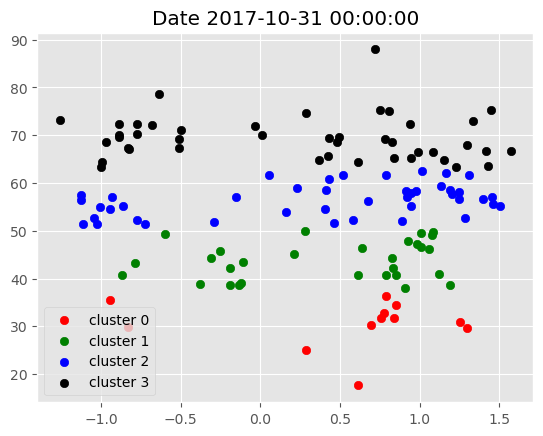

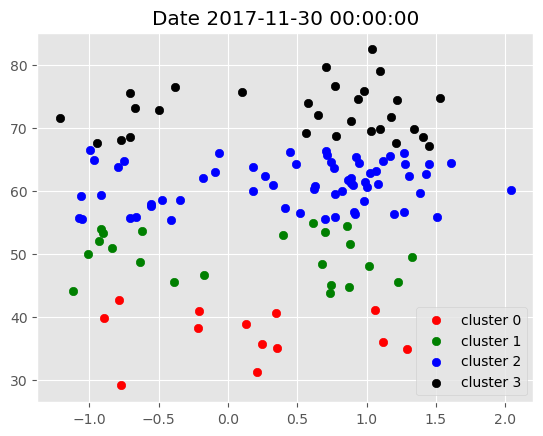

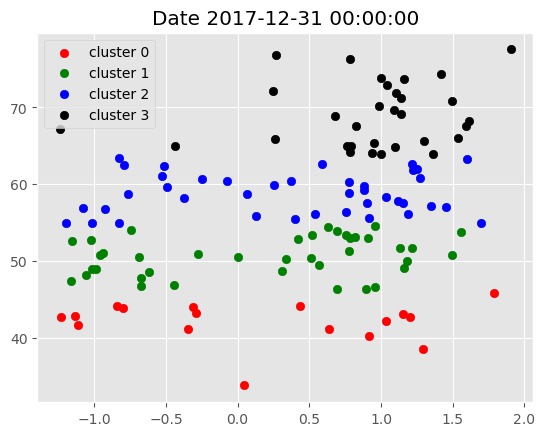

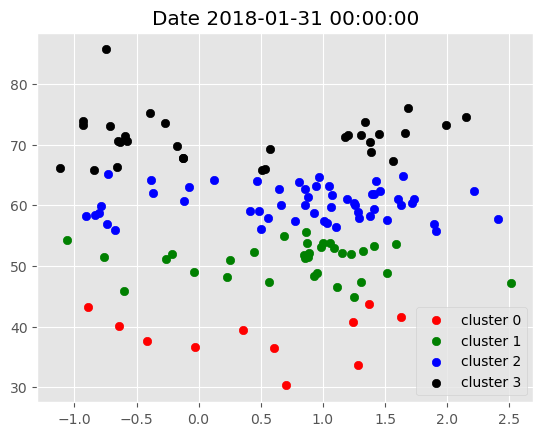

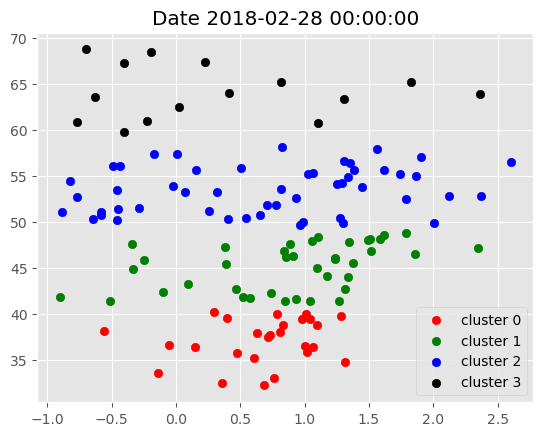

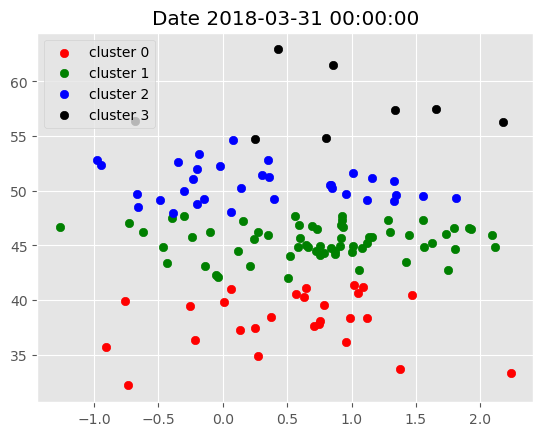

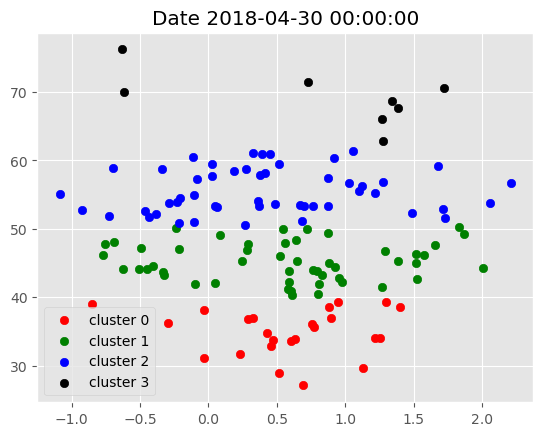

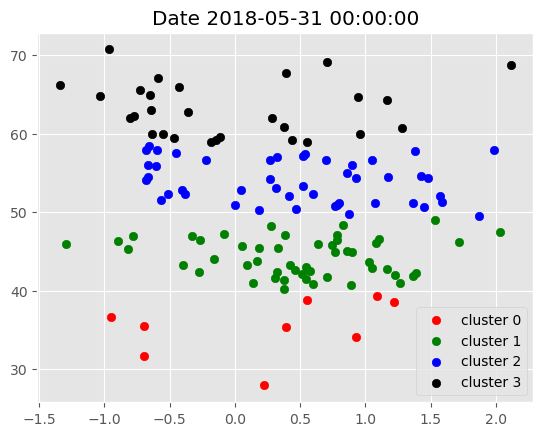

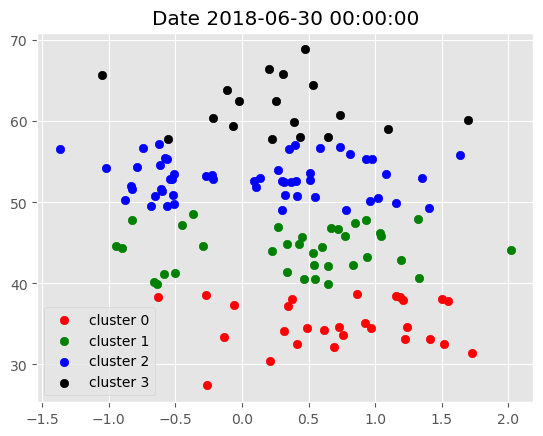

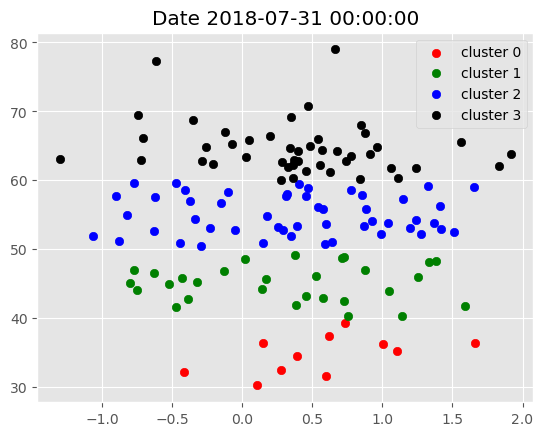

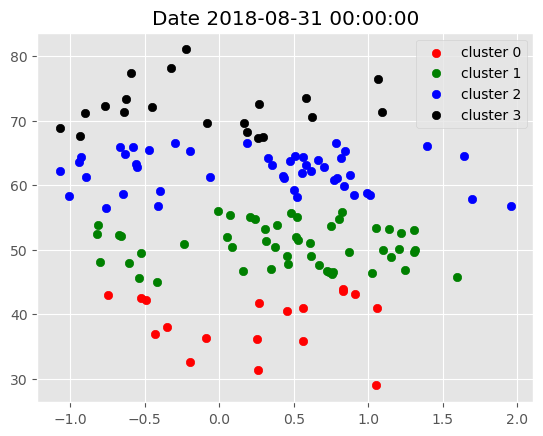

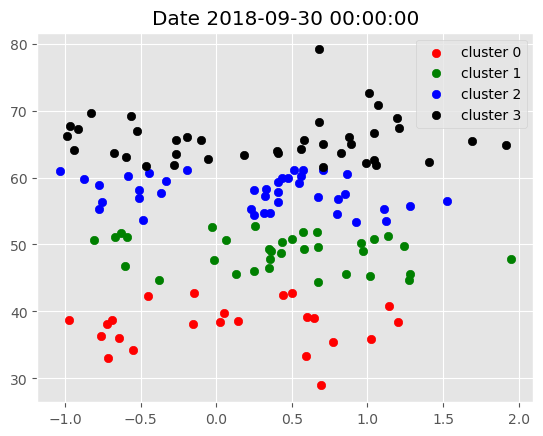

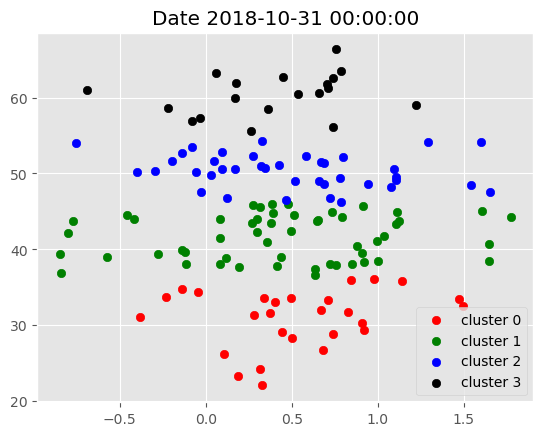

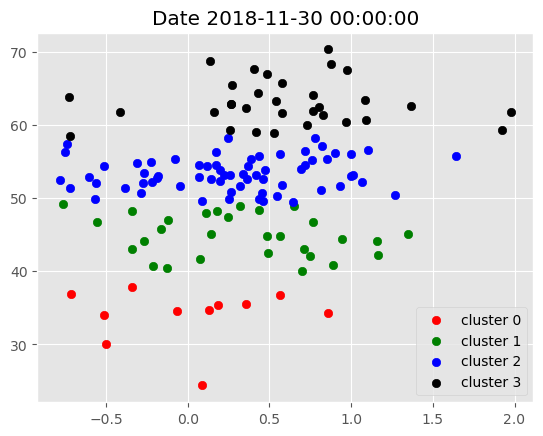

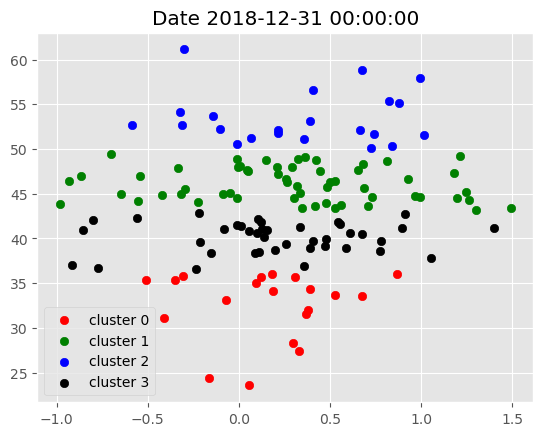

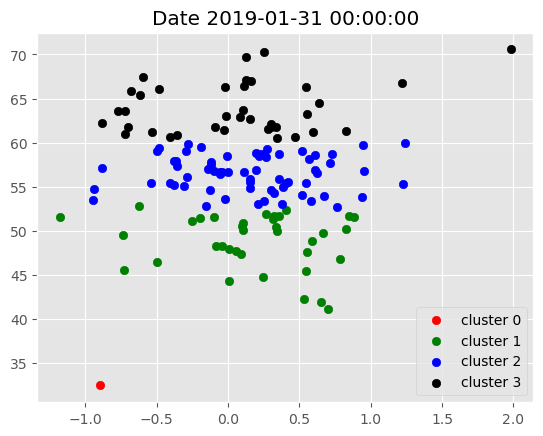

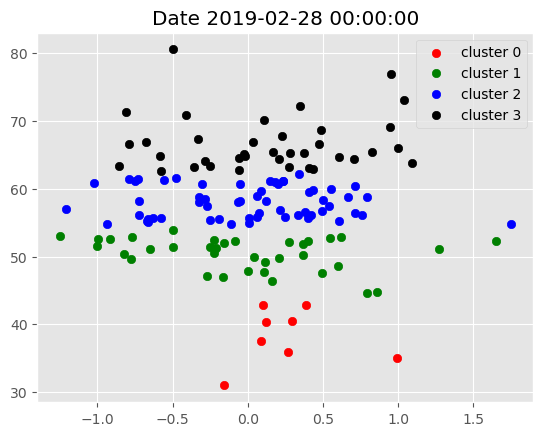

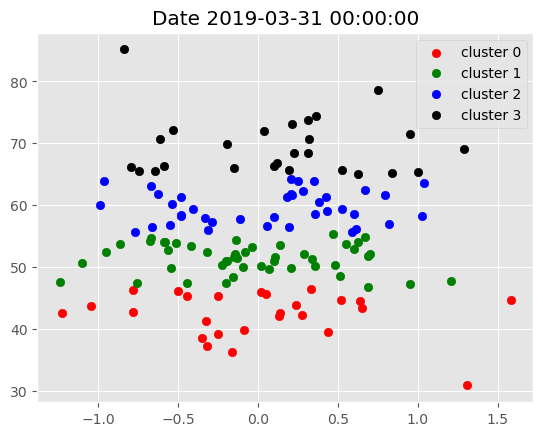

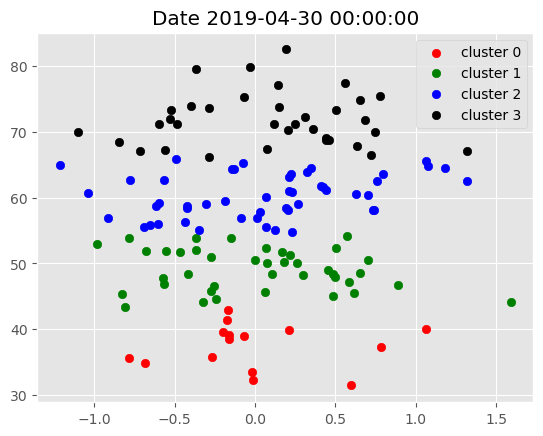

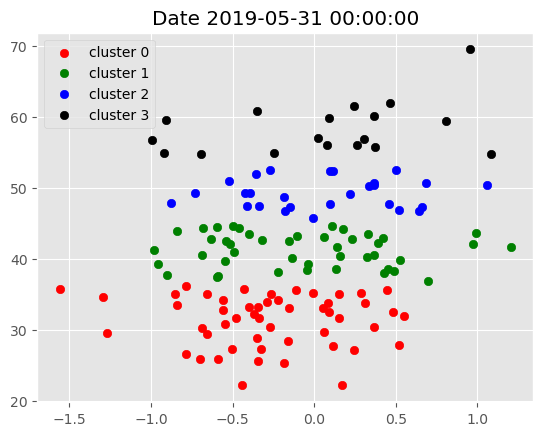

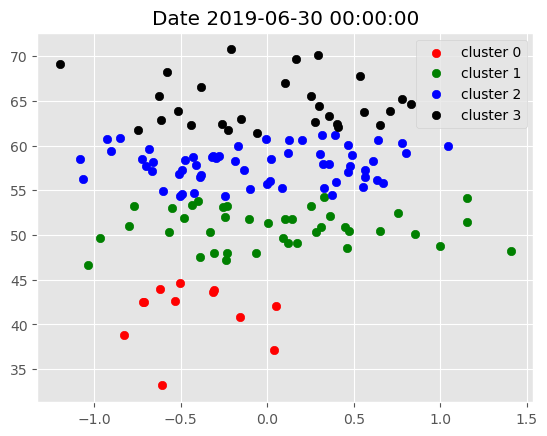

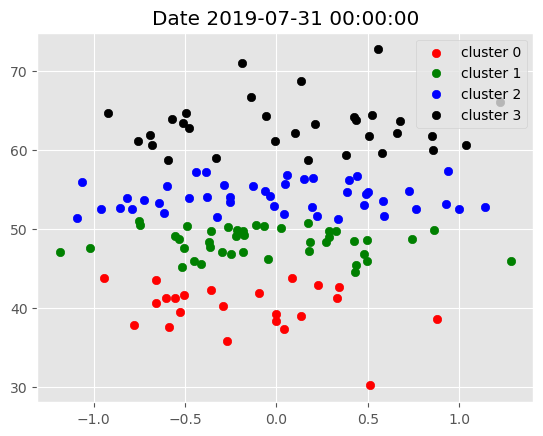

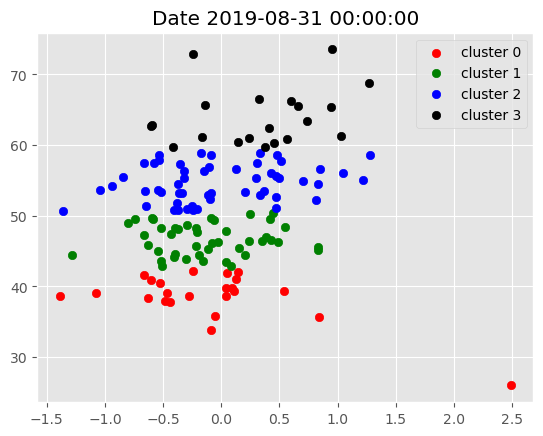

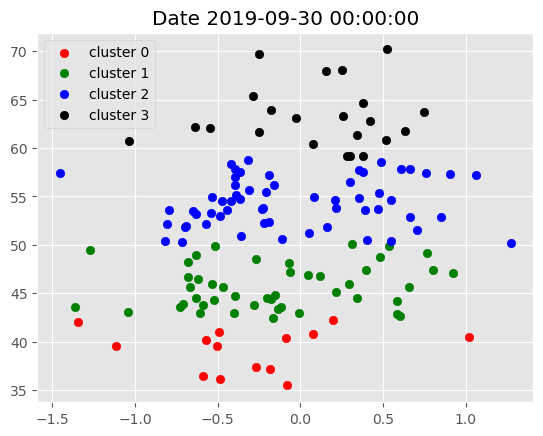

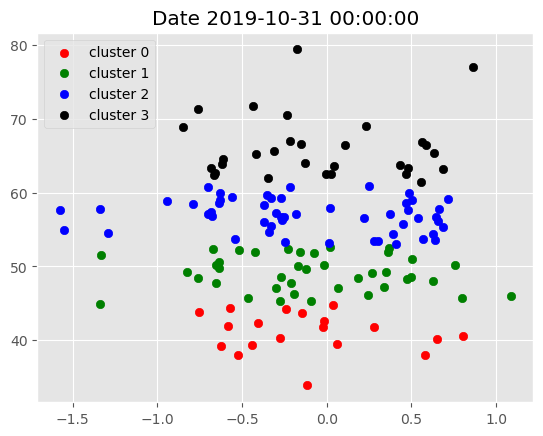

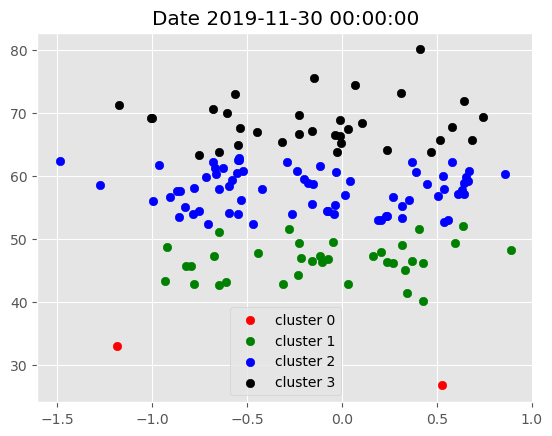

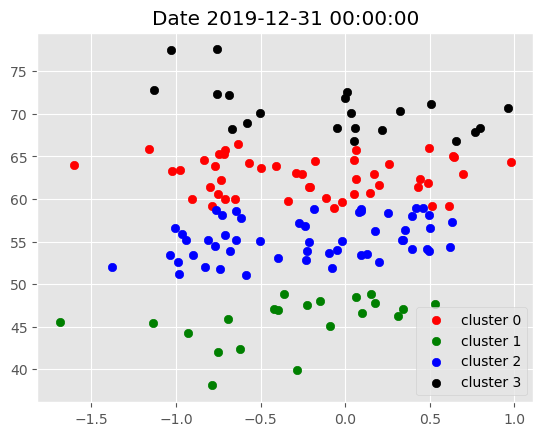

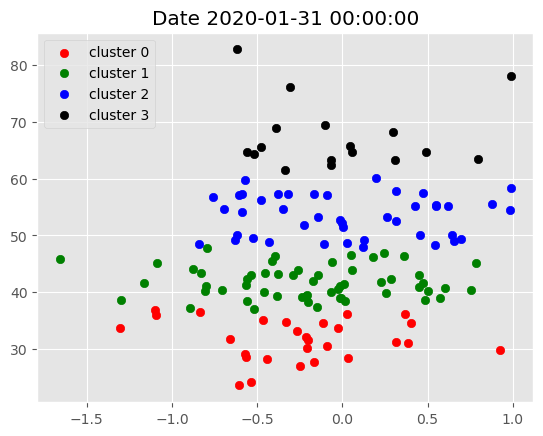

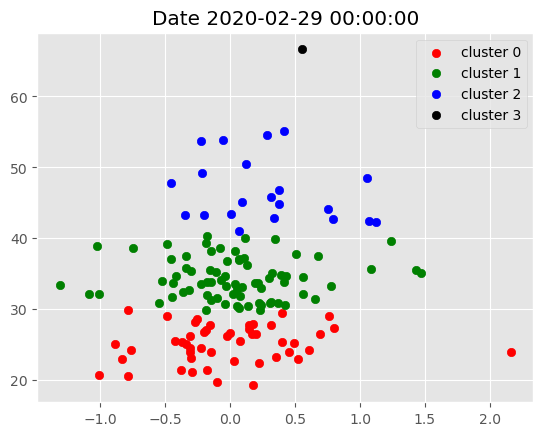

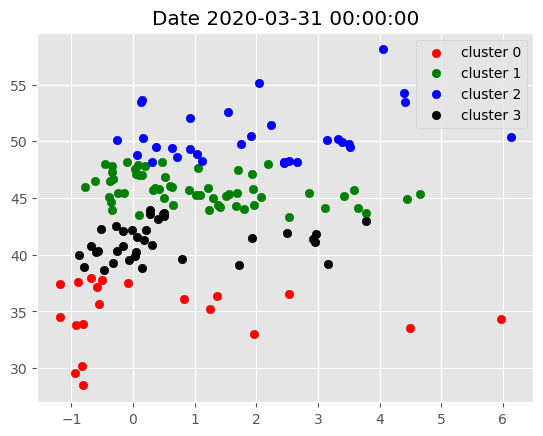

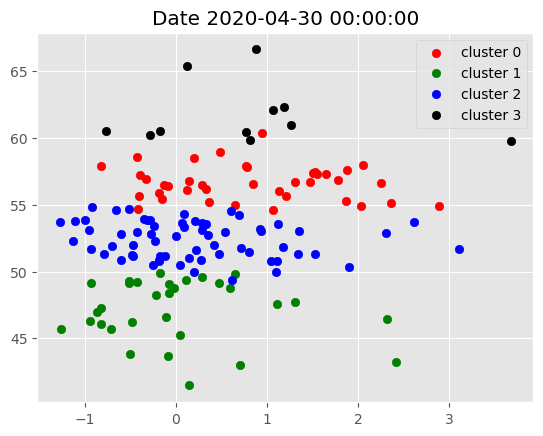

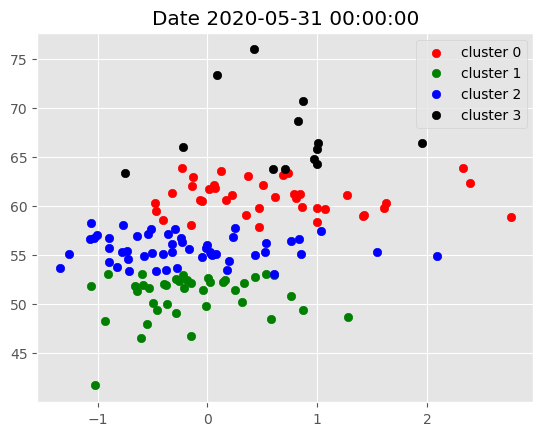

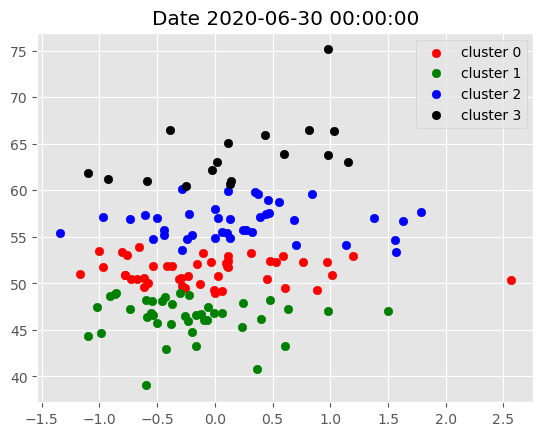

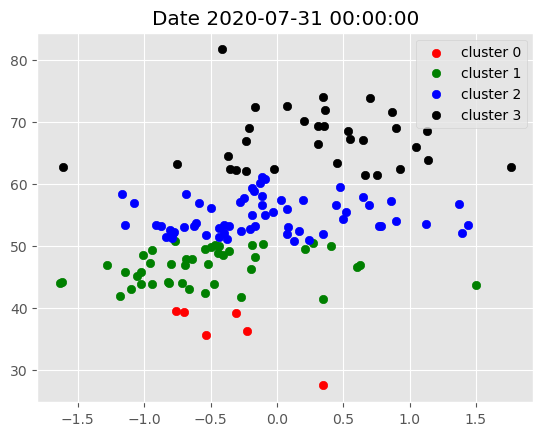

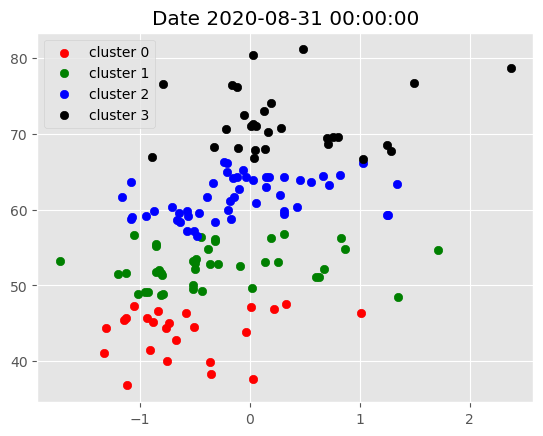

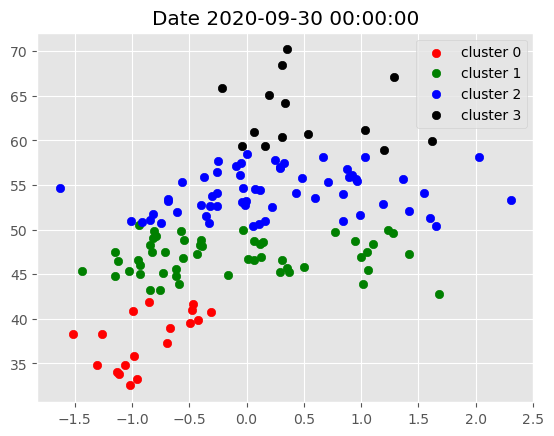

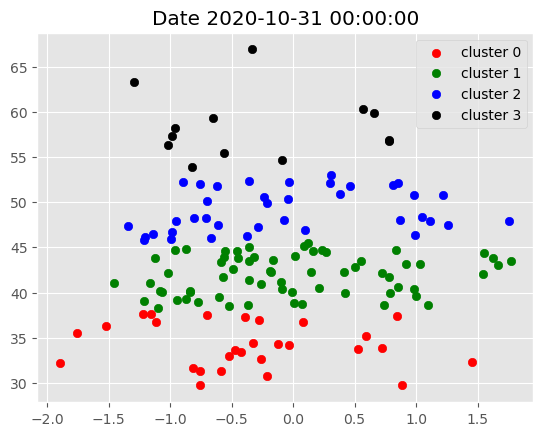

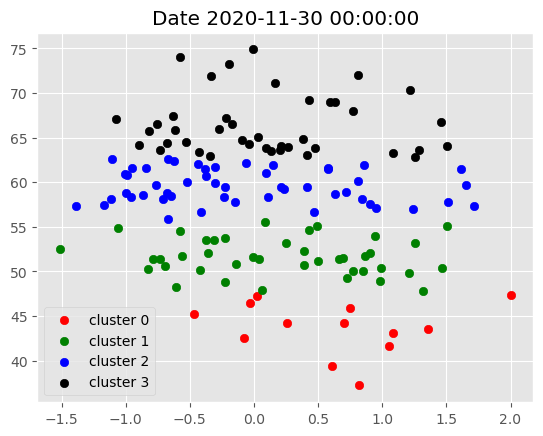

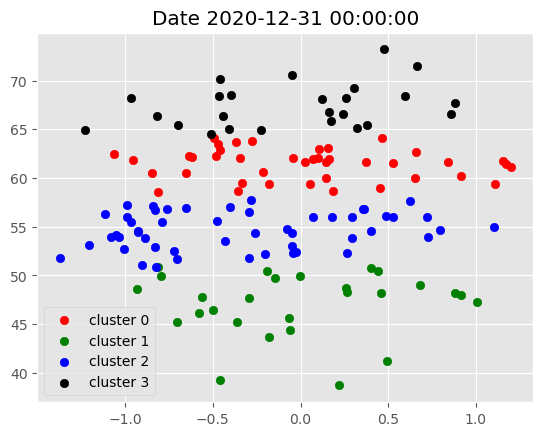

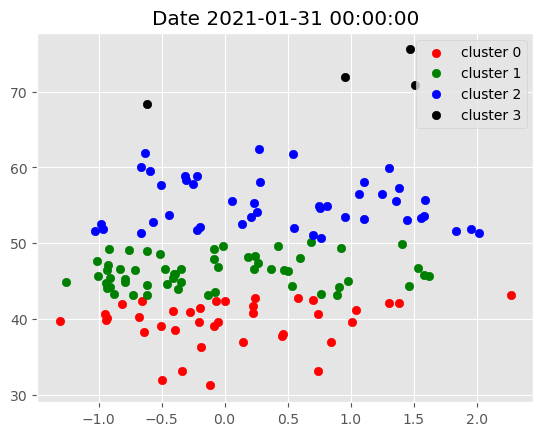

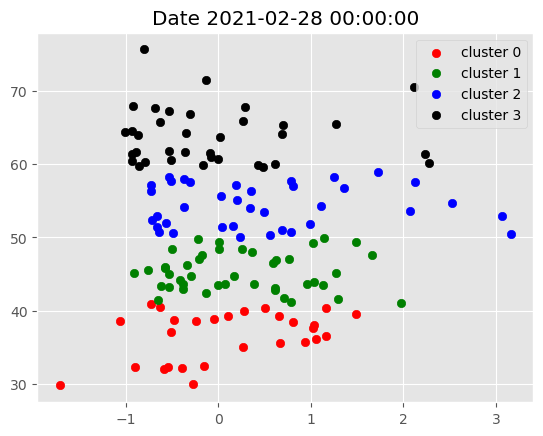

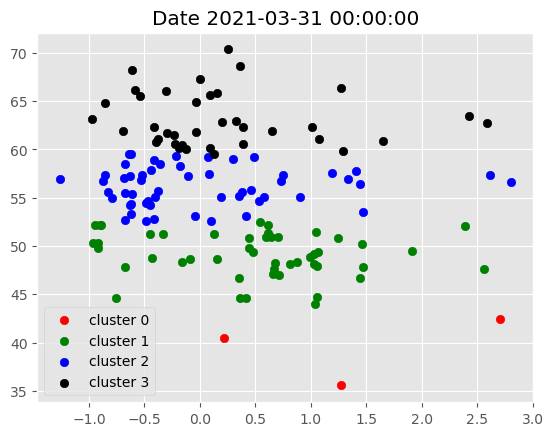

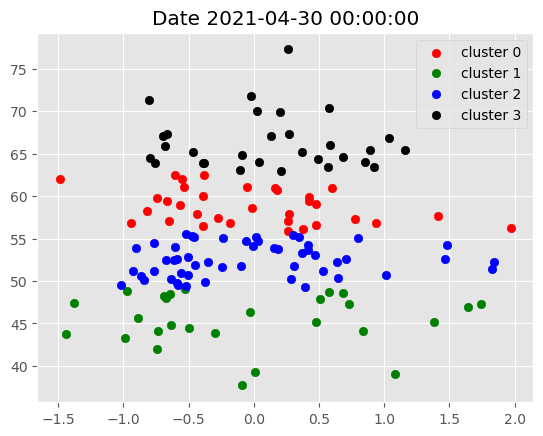

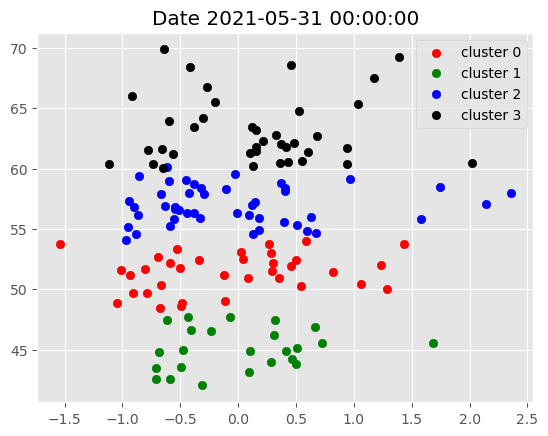

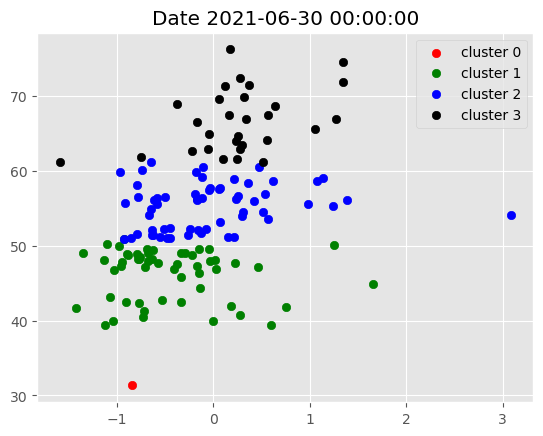

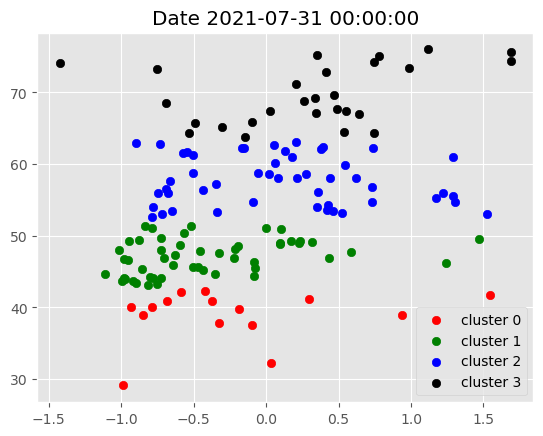

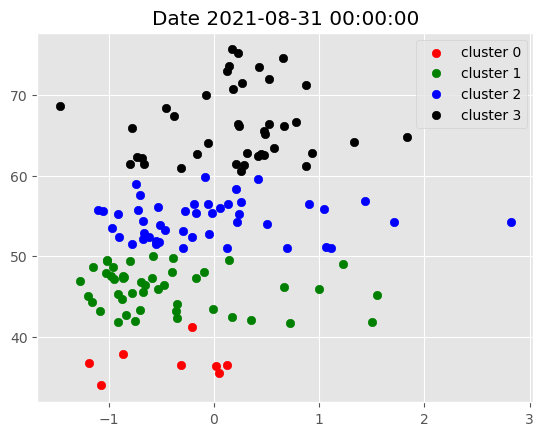

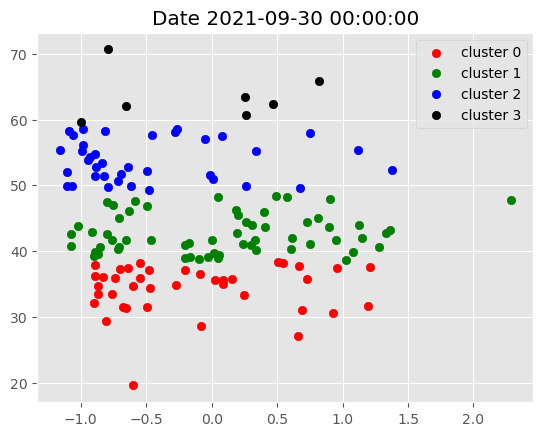

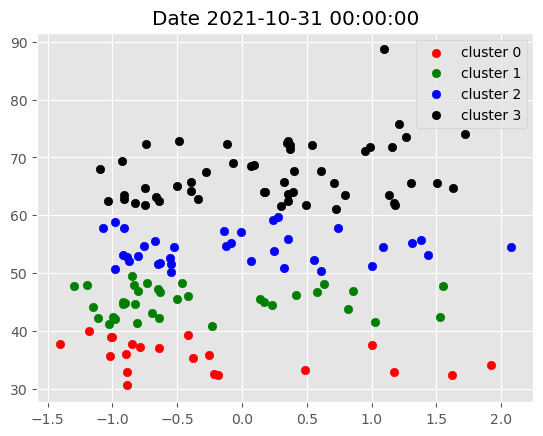

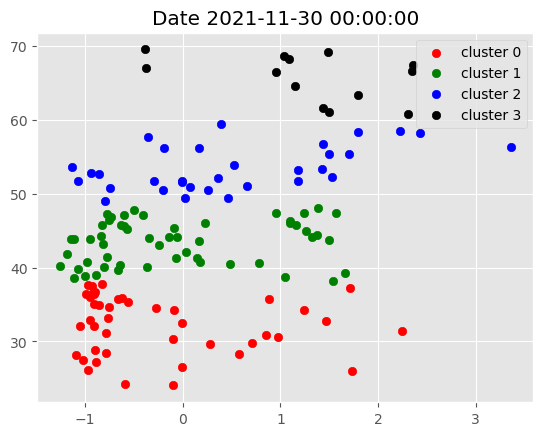

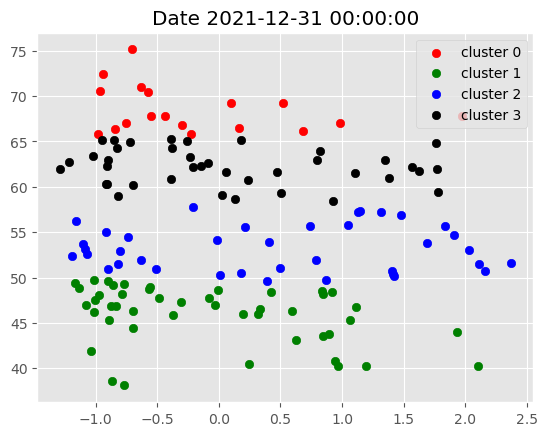

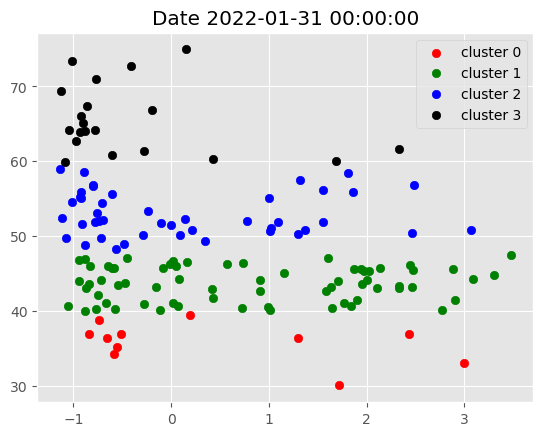

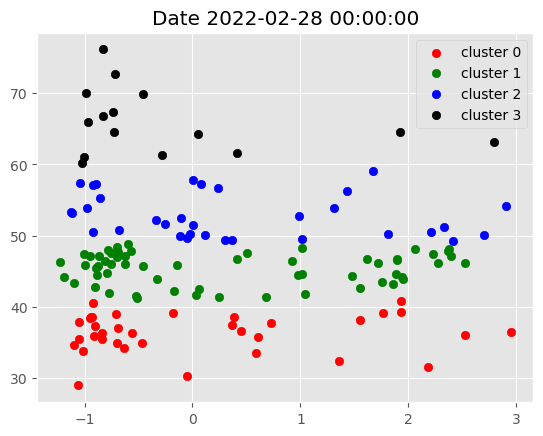

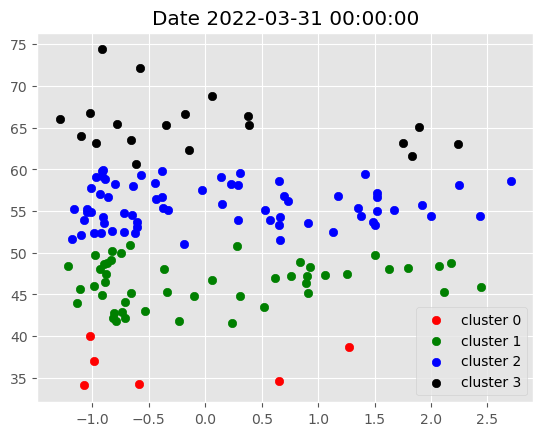

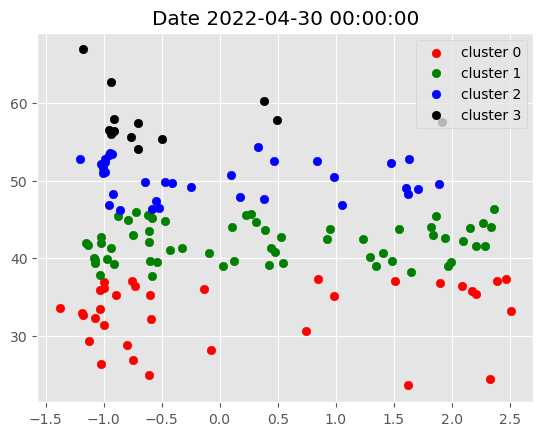

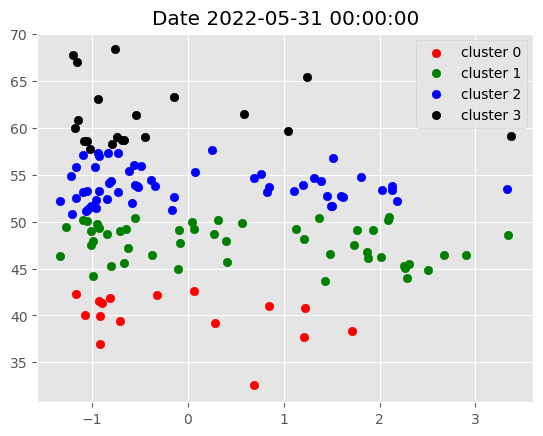

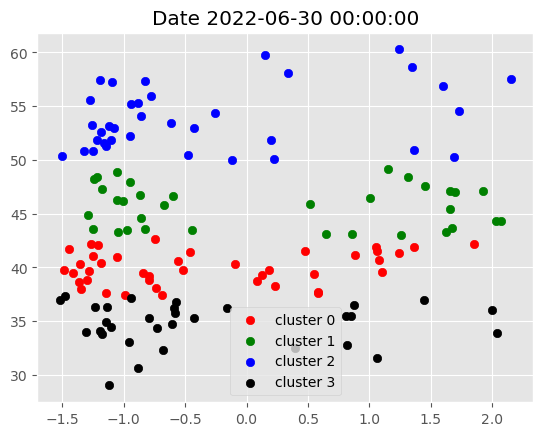

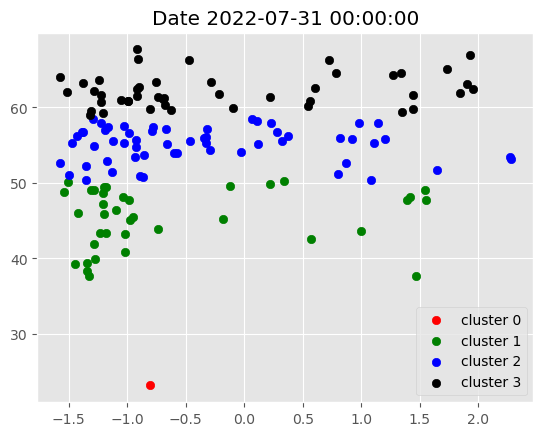

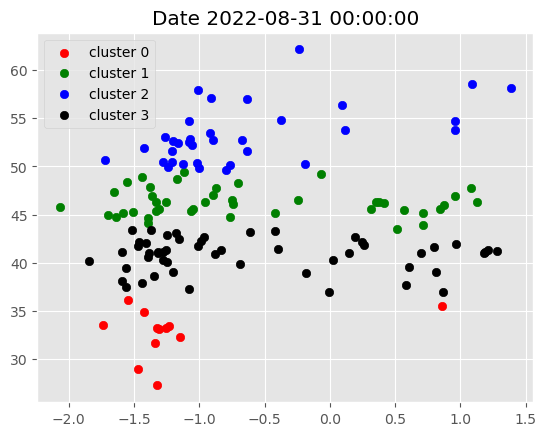

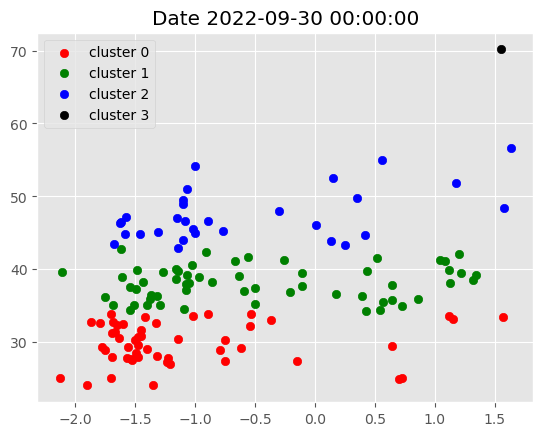

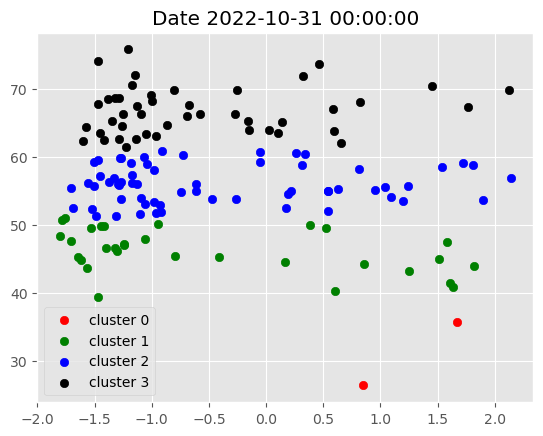

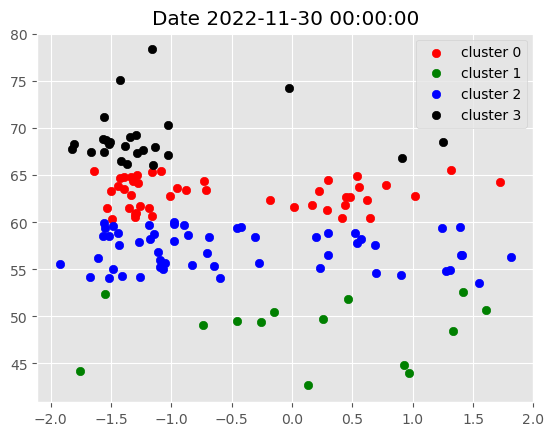

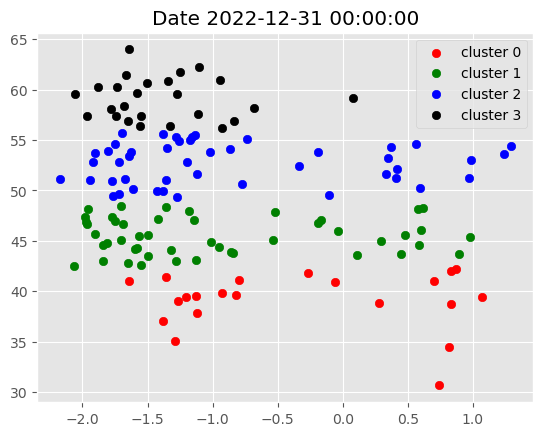

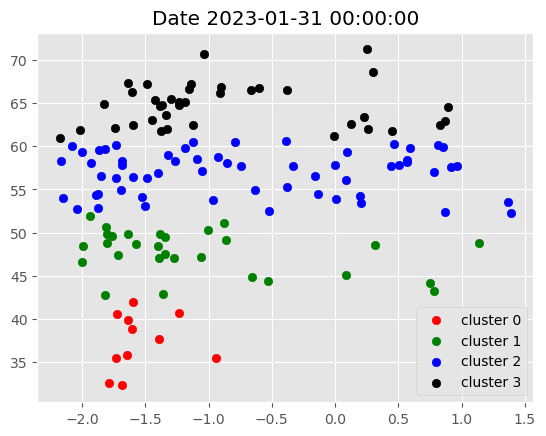

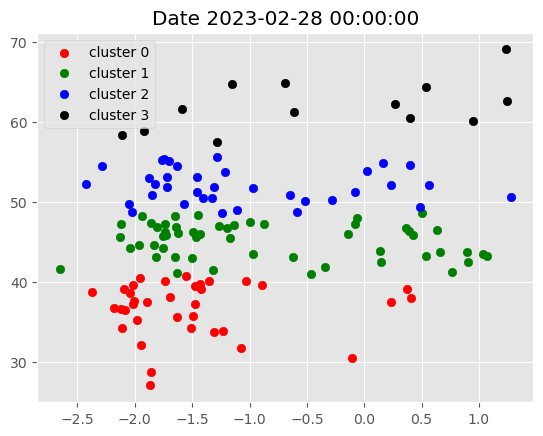

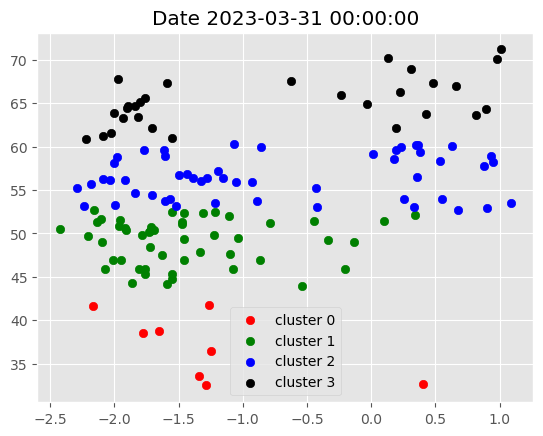

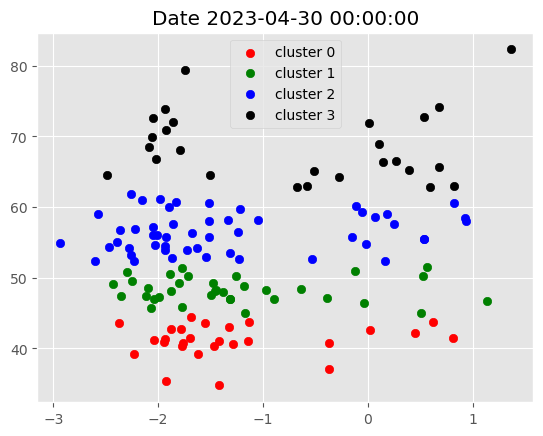

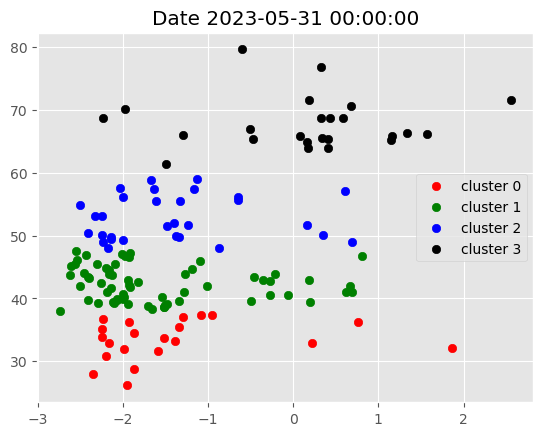

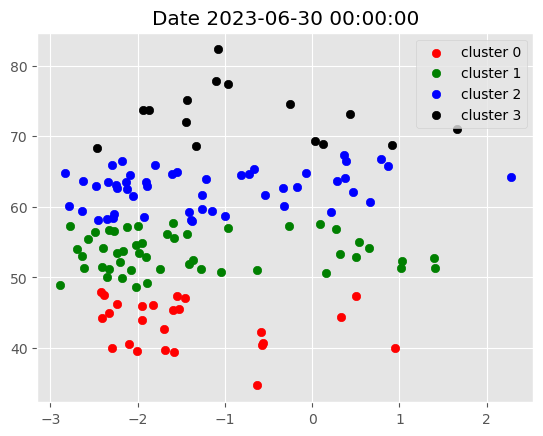

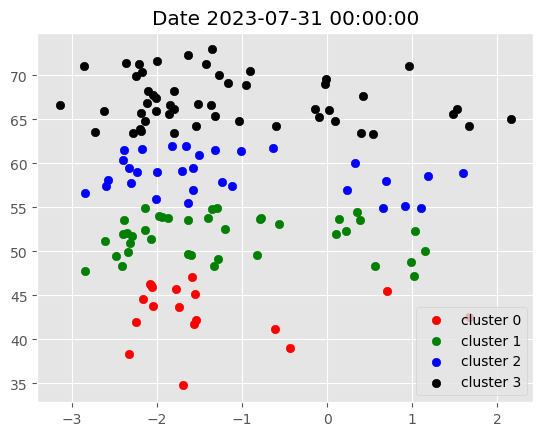

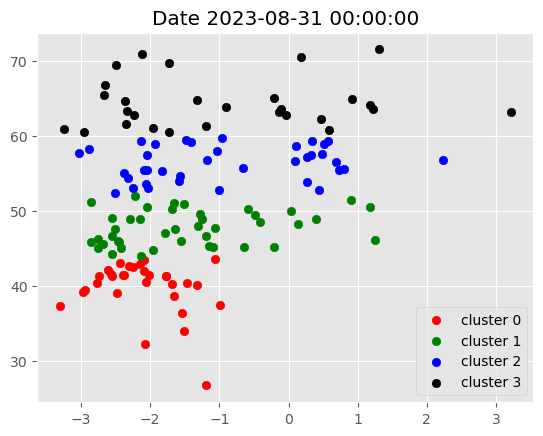

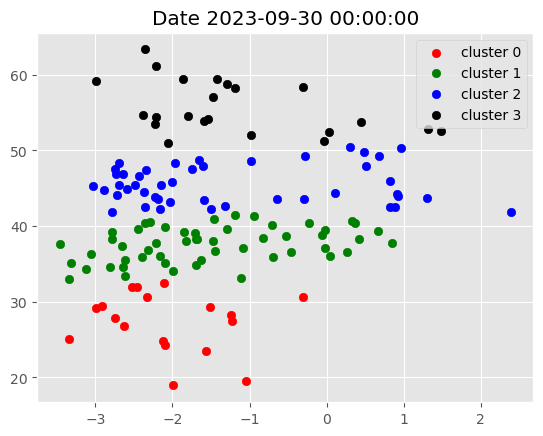

In [12]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    g = data.xs(i, level=0)
    plt.title(f'Date {i}')
    plot_clusters(g)

## **7. For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization**

In [13]:
filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index + pd.DateOffset(days=1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()

fixed_dates

{'2017-11-01': ['AAPL',
  'ACN',
  'ADBE',
  'AMAT',
  'AMZN',
  'AVGO',
  'AXP',
  'BAC',
  'CAT',
  'COP',
  'CRM',
  'CTSH',
  'DE',
  'DHR',
  'DLTR',
  'ELV',
  'EOG',
  'GOOG',
  'GOOGL',
  'INTC',
  'ISRG',
  'JPM',
  'MA',
  'MAR',
  'MCD',
  'MET',
  'META',
  'MMM',
  'MSFT',
  'MU',
  'NEE',
  'NVDA',
  'NXPI',
  'ORCL',
  'PYPL',
  'SHW',
  'STZ',
  'TXN',
  'UNH',
  'V',
  'VLO',
  'WMT',
  'XOM'],
 '2017-12-01': ['AMZN',
  'AXP',
  'AZO',
  'BA',
  'BAC',
  'BRK-B',
  'CAT',
  'COST',
  'CSCO',
  'DE',
  'DLTR',
  'ELV',
  'HD',
  'HON',
  'ILMN',
  'JPM',
  'KR',
  'LUV',
  'MAR',
  'MMM',
  'NKE',
  'ORLY',
  'OXY',
  'SCHW',
  'UNH',
  'UNP',
  'VLO',
  'VZ',
  'WMT'],
 '2018-01-01': ['ACN',
  'BA',
  'BAC',
  'CAT',
  'CSCO',
  'CVX',
  'DAL',
  'DE',
  'DG',
  'EOG',
  'FCX',
  'FDX',
  'HAL',
  'HD',
  'KR',
  'LOW',
  'LUV',
  'MAR',
  'OXY',
  'PEP',
  'PXD',
  'RTX',
  'STZ',
  'T',
  'TXN',
  'UAL',
  'UNP',
  'VLO',
  'VZ',
  'WMT',
  'WYNN'],
 '2018-02-01': ['

### **Define portfolio optimization function**

In [14]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):
    returns = expected_returns.mean_historical_return(prices=prices, frequency=252)
    cov = risk_models.sample_cov(prices=prices, frequency=252)
    ef = EfficientFrontier(expected_returns=returns, cov_matrix=cov, weight_bounds=(lower_bound, 0.1), solver='SCS')
    weights = ef.max_sharpe()
    return ef.clean_weights()


In [23]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks, start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12), end=data.index.get_level_values('date').unique()[-1])

new_df

[*********************100%%**********************]  153 of 153 completed


Adj Close                                                 \
                  AAL        AAPL        ABBV        ABT         ACN   
Date                                                                   
2016-10-31  39.134327   26.281523   41.009079  34.630013  104.350304   
2016-11-01  38.363213   25.807005   41.501671  34.462337  104.260544   
2016-11-02  38.276459   25.830145   41.751621  34.153465  106.477905   
2016-11-03  38.054199   25.553278   41.089943  33.871052  104.987663   
2016-11-04  38.402084   25.322952   41.200226  34.497639  105.239052   
...               ...         ...         ...        ...         ...   
2023-09-25  12.910000  175.848328  153.117371  96.933411  315.680695   
2023-09-26  12.700000  171.733749  152.384705  95.700241  309.327057   
2023-09-27  12.610000  170.205750  151.612442  95.004089  313.081512   
2023-09-28  12.920000  170.465424  150.741165  97.579834  299.527710   
2023-09-29  12.810000  170.984741  147.582764  96.316818  305.841522   

                                                                       ...  \
                  ADBE         ADP        ADSK        AIG        AMAT  ...   
Date                                                                   ...   
2016-10-31  107.510002   75.138802   72.279999  51.253300   26.700008  ...   
2016-11-01  106.870003   75.017975   70.099998  50.405998   26.534740  ...   
2016-11-02  105.889999   77.658966   68.680000  50.298019   26.250109  ...   
2016-11-03  107.169998   77.097984   67.610001  48.304371   25.956295  ...   
2016-11-04  106.199997   76.882210   69.440002  47.664753   25.910391  ...   
...                ...         ...         ...        ...         ...  ...   
2023-09-25  511.600006  240.020004  205.669998  62.130001  136.297150  ...   
2023-09-26  506.299988  237.240005  201.660004  61.259998  133.792526  ...   
2023-09-27  502.600006  242.630005  202.279999  61.009998  134.770416  ...   
2023-09-28  504.670013  243.309998  207.889999  61.279999  137.923645  ...   
2023-09-29  509.899994  240.580002  206.910004  60.599998  138.153152  ...   

              Volume                                                           \
                   V      VLO     VRTX        VZ       WBA      WDC       WFC   
Date                                                                            
2016-10-31  10024000  4969500  1928200  12459400   4662100  3363200  20115900   
2016-11-01  10881500  7816800  2458200  13229400   5130800  3821100  20020200   
2016-11-02   9170900  7317600  2580400  16488200   9783100  4216200  19566600   
2016-11-03   7563100  3855900  2371000  12605100   4586500  3192600  14982700   
2016-11-04   7588100  3729900  1902100  14410200   7023900  2705600  27391600   
...              ...      ...      ...       ...       ...      ...       ...   
2023-09-25   5921600  3241900   698100  17616900   6891000  2685900  10624000   
2023-09-26   6193200  4936800   633600  18841600   7570500  3571100  15219400   
2023-09-27   6006700  3644000   860600  22083500  10182900  2547800  11815500   
2023-09-28   4203900  3587300   578900  18772100   7291500  3282000  12454600   
2023-09-29   6044200  4302200   896800  19759400  25659100  2512000  13119100   

                                        
                WMT     WYNN       XOM  
Date                                    
2016-10-31  6389000  1341600  16663800  
2016-11-01  8838600  3722300  13050600  
2016-11-02  7645300  2542400  11226100  
2016-11-03  6803900  9050400   8836500  
2016-11-04  7262100  3223800  13877100  
...             ...      ...       ...  
2023-09-25  3486500  1387800  11316000  
2023-09-26  4811900  1454000  11805400  
2023-09-27  5237000  2050000  23976200  
2023-09-28  3872400  1290400  16808100  
2023-09-29  6279300  1326800  18810700  

[1740 rows x 918 columns]

In [39]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    try:
        end_date = (pd.to_datetime(start_date) + pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date) - pd.DateOffset(months=12)).strftime('%Y-%m-%d')
        optimization_end_date = (pd.to_datetime(start_date) - pd.DateOffset(days=1)).strftime('%Y-%m-%d')

        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]

        success = False
        try:
            weights = optimize_weights(prices=optimization_df, lower_bound=round(1/(len(optimization_df.columns)*2), 3))
            weights = pd.DataFrame(weights, index=pd.Series(0))

            success = True
        except:
            print(f'Max Sharpe Optimization Failed for {start_date}, Continuing with Equally-Weights')

        if success == False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))], index=optimization_df.columns.tolist(), columns=pd.Series(0)).T

        temp_df = returns_dataframe[start_date:end_date]
        temp_df = temp_df.stack().to_frame('return').reset_index(level=0).merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True), left_index=True, right_index=True).reset_index().set_index(['Date', 'index']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
    except Exception as e:
        print(e)
    
portfolio_df = portfolio_df.drop_duplicates()

portfolio_df

Max Sharpe Optimization Failed for 2018-04-01, Continuing with Equally-Weights
Max Sharpe Optimization Failed for 2018-05-01, Continuing with Equally-Weights
Max Sharpe Optimization Failed for 2019-01-01, Continuing with Equally-Weights
Max Sharpe Optimization Failed for 2020-03-01, Continuing with Equally-Weights
Max Sharpe Optimization Failed for 2020-04-01, Continuing with Equally-Weights
Max Sharpe Optimization Failed for 2021-02-01, Continuing with Equally-Weights
Max Sharpe Optimization Failed for 2021-10-01, Continuing with Equally-Weights
Max Sharpe Optimization Failed for 2022-07-01, Continuing with Equally-Weights
Max Sharpe Optimization Failed for 2022-09-01, Continuing with Equally-Weights
Max Sharpe Optimization Failed for 2022-10-01, Continuing with Equally-Weights
'return'


,Strategy Return
date,
2017-11-01,0.001361
2017-11-02,0.002909
2017-11-03,0.006310
2017-11-06,0.003008
2017-11-07,0.002704
...,...
2023-09-25,0.003641
2023-09-26,-0.011470
2023-09-27,0.005189


## **8. Visualize Portfolio returns and compare to SP500 returns**

In [46]:
spy = yf.download(tickers='SPY', start='2015-01-01', end='2023-12-03')

spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close': 'SPY Buy&Hold'}, axis=1)

portfolio_df = portfolio_df.merge(spy_ret, left_index=True, right_index=True)

portfolio_df

[*********************100%%**********************]  1 of 1 completed


,Strategy Return,SPY Buy&Hold
2017-11-01,0.001361,0.001321
2017-11-02,0.002909,0.000388
2017-11-03,0.006310,0.003333
2017-11-06,0.003008,0.001546
2017-11-07,0.002704,-0.000696
...,...,...
2023-09-25,0.003641,0.004196
2023-09-26,-0.011470,-0.014800
2023-09-27,0.005189,0.000399
2023-09-28,0.007977,0.005781


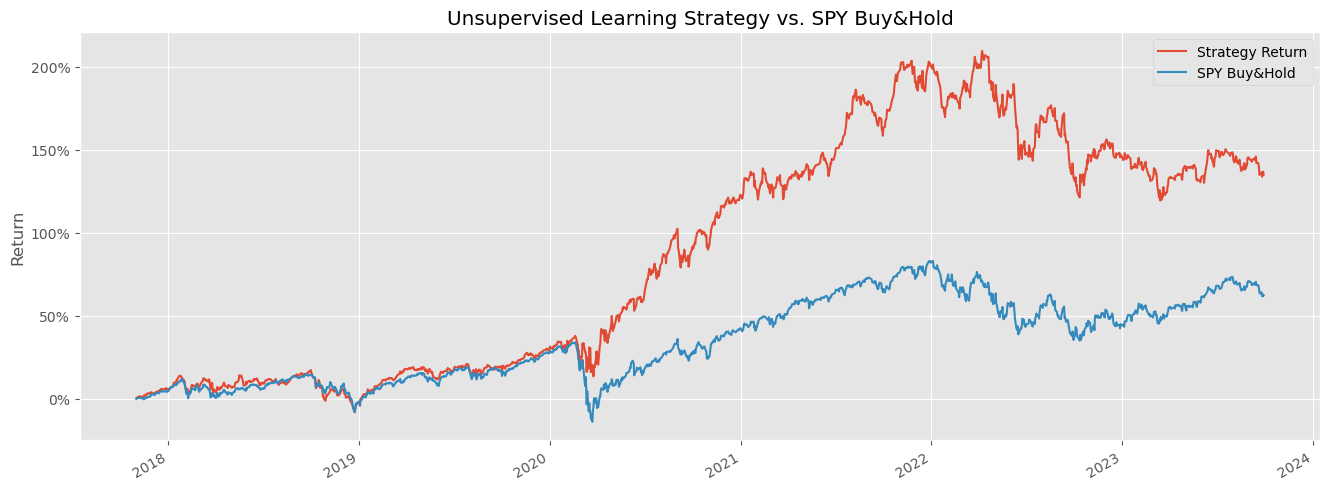

In [50]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_returns = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_returns[:'2023-09-29'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Strategy vs. SPY Buy&Hold')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()